# 1 题目信息

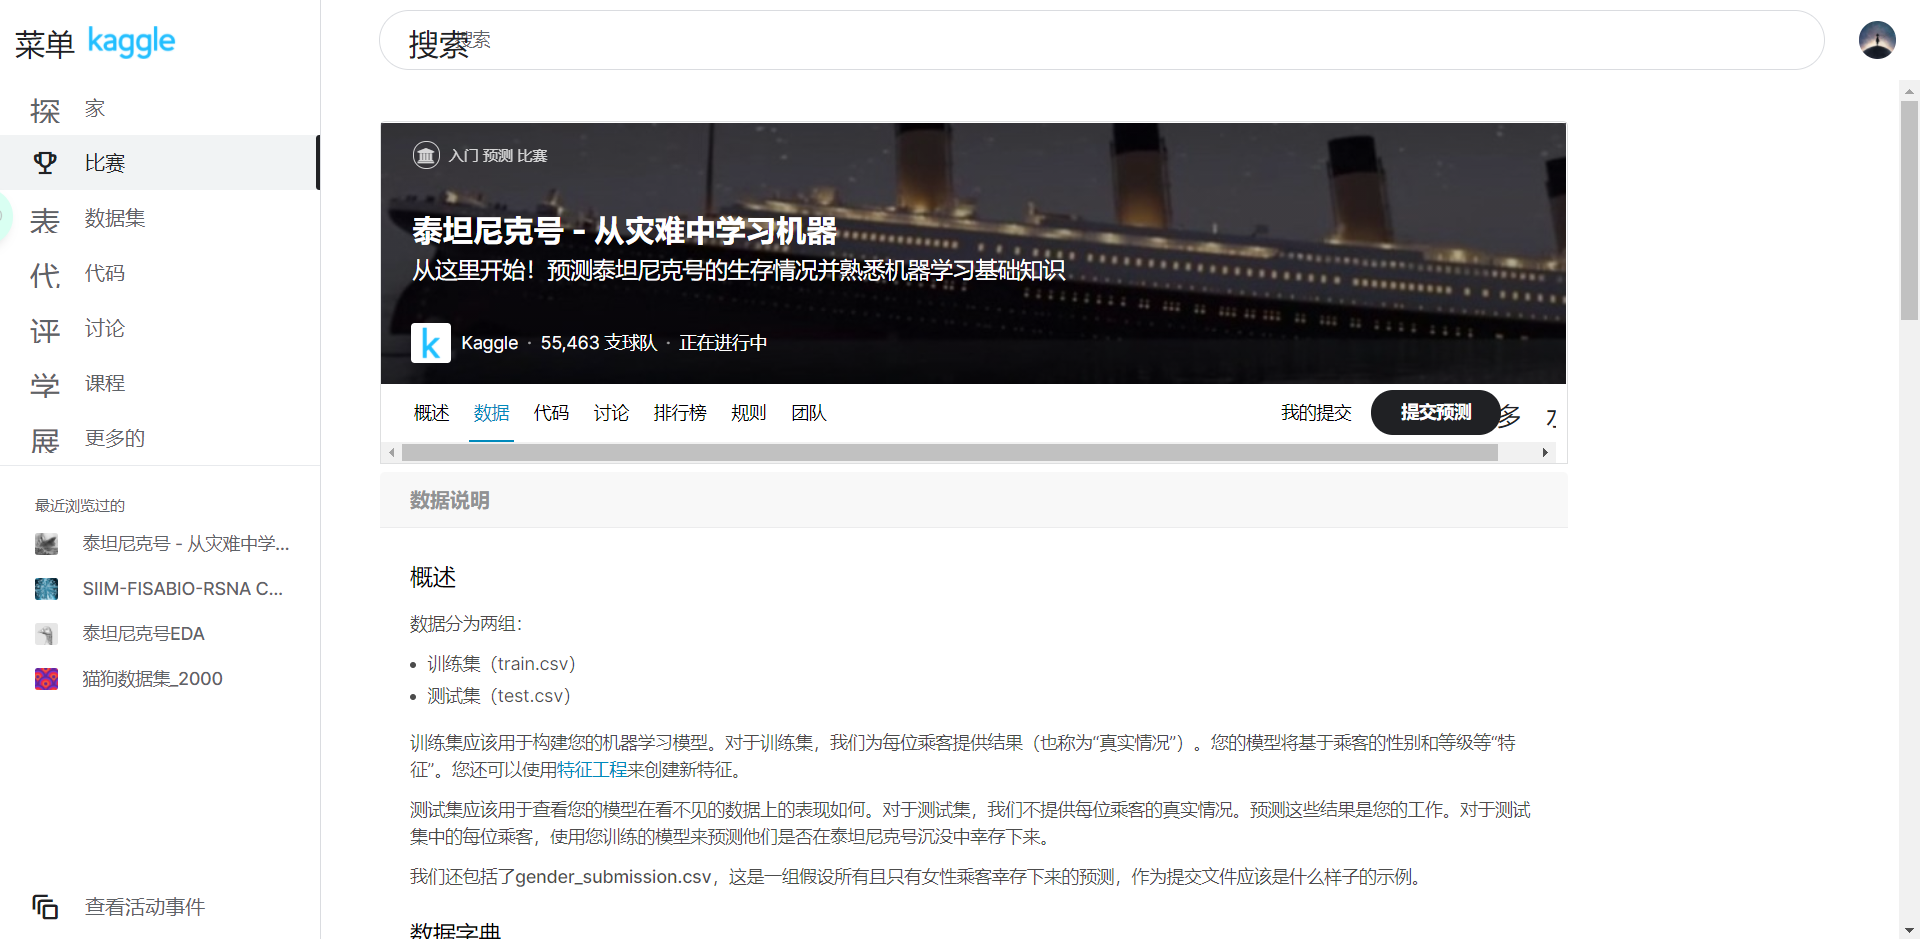

## 1.1 概述

>泰坦尼克号的沉没是历史上最臭名昭著的沉船之一。

>1912 年 4 月 15 日，在她的处女航期间，被广泛认为“不沉”的泰坦尼克号在与冰山相撞后沉没。不幸的是，船上的每个人都没有足够的救生艇，导致 2224 名乘客和船员中有 1502 人死亡。

>虽然幸存下来有一些运气因素，但似乎有些人比其他人更有可能幸存下来。

>在这个挑战中，我们要求您构建一个预测模型来回答这个问题：“什么样的人更有可能生存？” 使用乘客数据（即姓名、年龄、性别、社会经济阶层等）。

## 1.2 数据

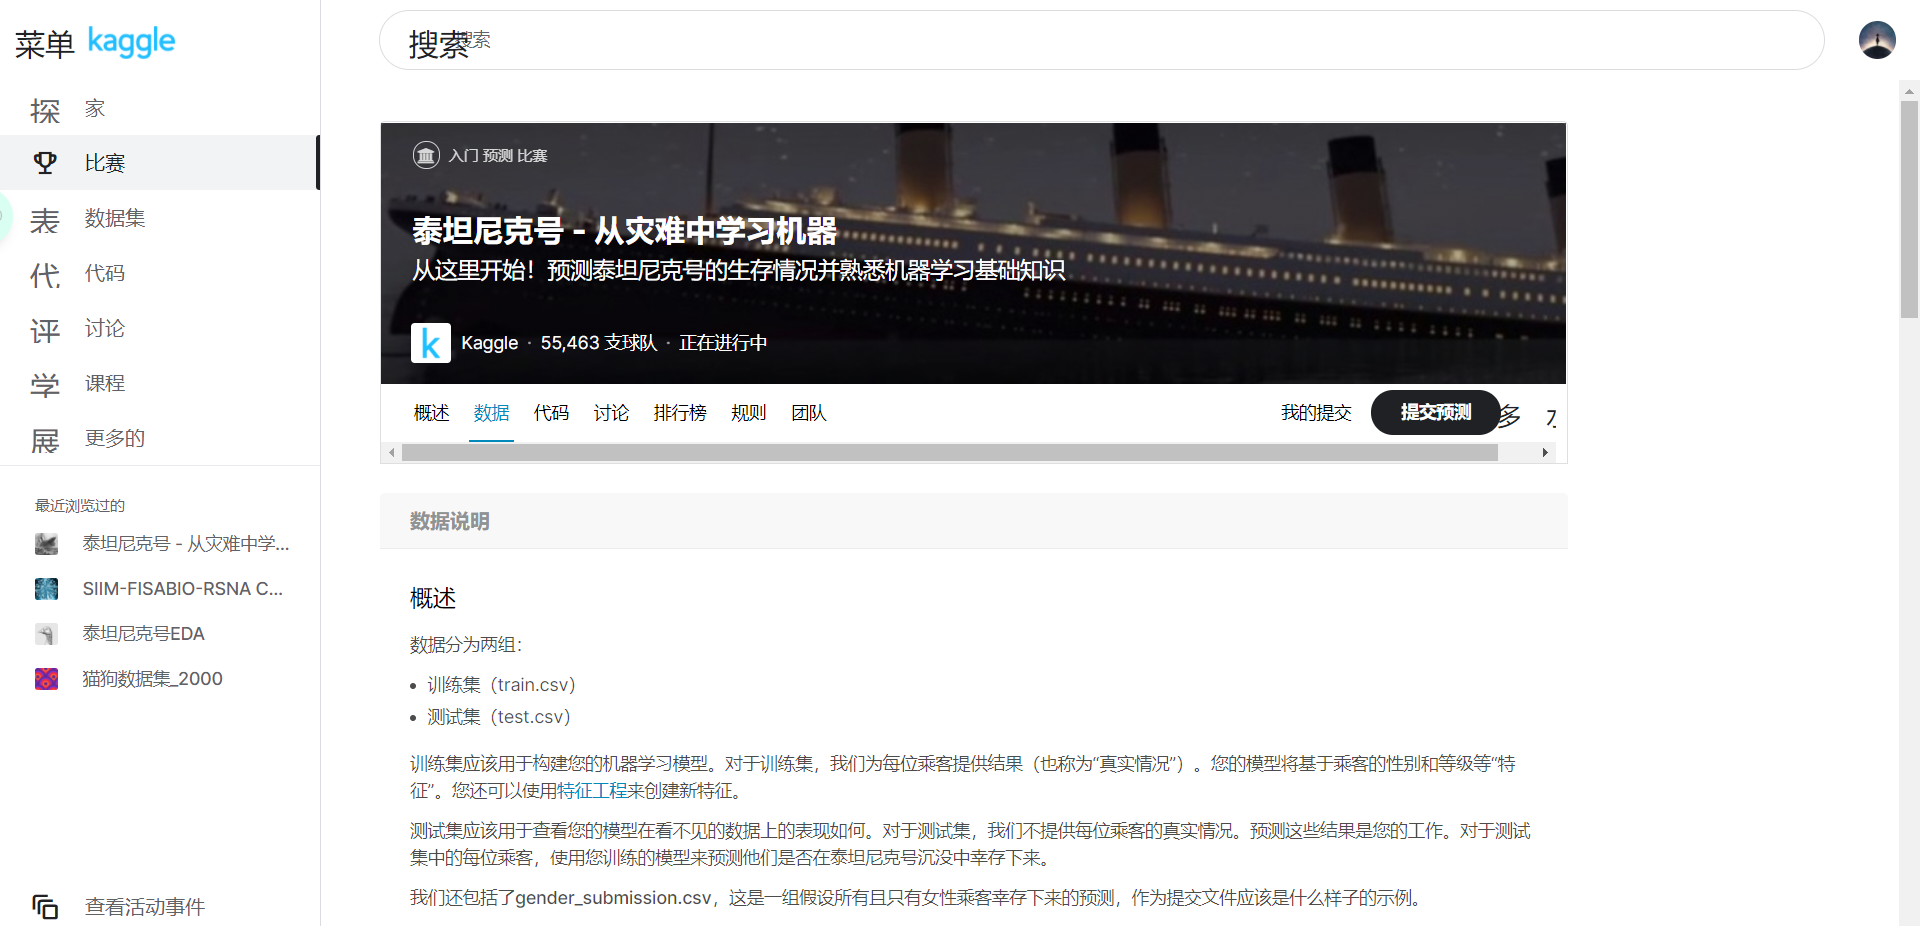

# 2 数据导入和初步观察
导入泰坦尼克号训练集和测试集的数据，这次选择同时处理两份数据，所以直接将他们拼接起来

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
datas = pd.concat([train, test], ignore_index = True)

查看数据的组成

In [2]:
train.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


可以看到我们的数据集有12个特征。每个特征的重要程度和作用大致如下：

|特征|	作用和重要程度|
| :-----: | :----: |
|乘客ID|	索引|
|是否生存|	0代表死亡，1代表存活|
|社会等级|	分为1，2，3等级|
|姓名|	重要，可以提炼出大量有用的信息|
|性别|	重要|
|年龄|	重要|
|直系亲友|	一般，和旁系亲友共同处理|
|旁系亲友|	一般，和直系亲友共同处理|
|票号|	一般|
|票价|	重要|
|舱门编号|	一般|
|上船时的港口编号|	一般|

查看数据集的缺失情况

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


可以看到特征还是比较完整的，只有三个特征有缺失的情况，分别是年龄，舱门编号和上船时的港口编号。其中年龄和舱门编号缺失的值比较多，需要特殊处理一下。

# 3 数据分析和特征工程
## 3.1 数据分析
### 3.1.1 死亡与存活的比例

In [4]:
train['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

### 3.1.2 社会等级对存活的影响：社会等级越高，存活率越高

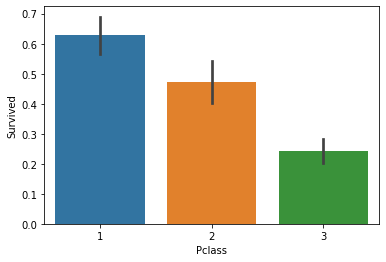

In [5]:
sns.barplot(x="Pclass", y="Survived", data=datas)

### 3.1.3 性别对存活的影响：女性的存活率远大于男性

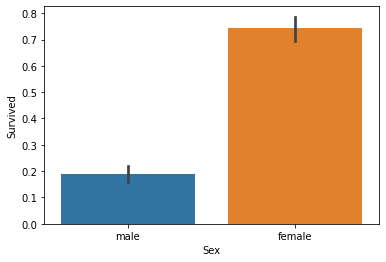

In [6]:
sns.barplot(x="Sex", y="Survived", data=datas)

### 3.1.4 年龄对存活的影响：在0~35岁中的人群具有更高的生存概率，高于35岁的人群生存概率较低

Text(12.403240740740742, 0.5, 'Survived')

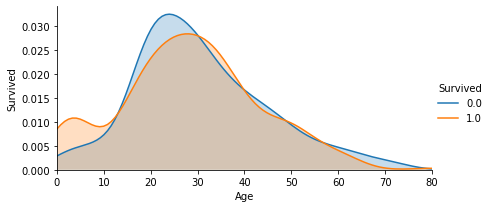

In [7]:
facet = sns.FacetGrid(datas, hue="Survived",aspect=2)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, train['Age'].max()))
facet.add_legend()
plt.xlabel('Age') 
plt.ylabel('Survived') 

### 3.1.5 亲属对存活的影响：拥有2~4位家庭成员的人存活率更高

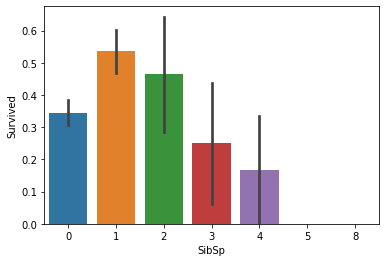

In [8]:
sns.barplot(x="SibSp", y="Survived", data=datas)

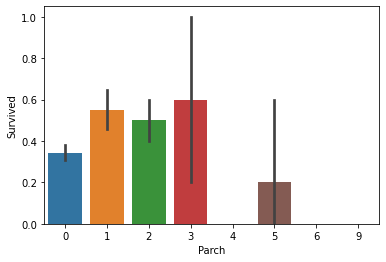

In [9]:
sns.barplot(x="Parch", y="Survived", data=datas)

将直系和旁系亲属两个特征合并为家庭大小，可以更直观地观察亲属这个特征对存活率的影响

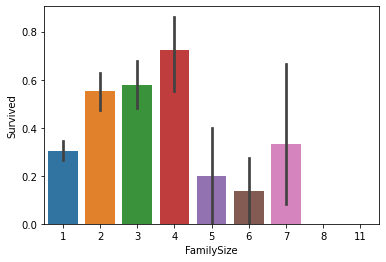

In [10]:
datas['FamilySize']=datas['SibSp']+datas['Parch']+1
sns.barplot(x="FamilySize", y="Survived", data=datas)

### 3.1.6 登船时港口的不同对存活的影响：C和Q地的存活率更高，S地的存活率较低

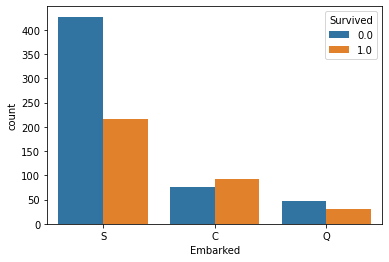

In [11]:
sns.countplot('Embarked',hue='Survived',data=datas)

## 3.2 特征工程

### 3.2.1 名字的处理
名字的处理在数据分析中可以看到，社会等级对存活率影响非常明显，所以可以将姓名替换为称呼前缀，生成新的特征‘Title’，用来对应社会等级。这样就将一大串看似没有用的姓名特征转化成了有用的分类型特征。

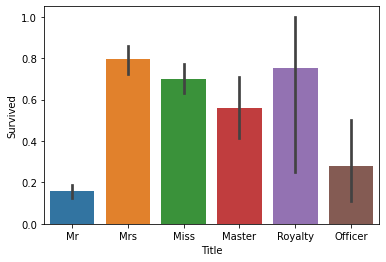

In [12]:
datas['Title'] = datas['Name'].apply(lambda x:x.split(',')[1].split('.')[0].strip())
datas['Title'].replace(['Capt', 'Col', 'Major', 'Dr', 'Rev'],'Officer', inplace=True)
datas['Title'].replace(['Don', 'Sir', 'the Countess', 'Dona', 'Lady'], 'Royalty', inplace=True)
datas['Title'].replace(['Mme', 'Ms', 'Mrs'],'Mrs', inplace=True)
datas['Title'].replace(['Mlle', 'Miss'], 'Miss', inplace=True)
datas['Title'].replace(['Master','Jonkheer'],'Master', inplace=True)
datas['Title'].replace(['Mr'], 'Mr', inplace=True)

sns.barplot(x="Title", y="Survived", data=datas)

**代表女士的Mrs,Miss和代表社会高层的Master,Royalty的生存率远远高于代表男性的Mr和社会中低层的Officer。**

### 3.2.2 家庭特征的处理
在家庭大小特征的分析中我们可以知道，拥有不同家庭成员数量的人存活率不相同。在这里我们将存活率相似的部分归为一类，将家庭大小特征转化为分类型特征。

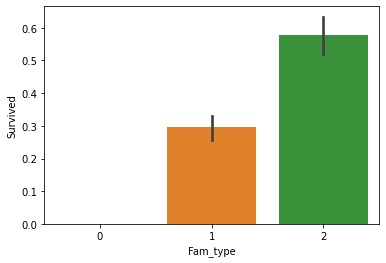

In [13]:
datas['Fam_size'] = datas['SibSp'] + datas['Parch'] + 1

datas.loc[datas['Fam_size']>7,'Fam_type']=0
datas.loc[(datas['Fam_size']>=2)&(datas['Fam_size']<=4),'Fam_type']=2
datas.loc[(datas['Fam_size']>4)&(datas['Fam_size']<=7)|(datas['Fam_size']==1),'Fam_type']=1
datas['Fam_type']=datas['Fam_type'].astype(np.int32)

sns.barplot(x="Fam_type", y="Survived", data=datas)

**代表拥有2—4位家庭成员的“Fam_type.2”拥有更高的存活率**

### 3.2.3 舱门数据处理
处理有大量缺失值的舱门数据。关键思想是：要将特征尽可能的处理为分类型特征。那么就有两种思路：**①缺失值分一类，不缺失的值分为一类 ②缺失值分一类，剩下确定的值再细分类，** 很明显要选择第二种思路。 **现在将缺失值全部用‘U’来填补，已经确定的舱门号则提取出它的首字母作为它的新特征甲板号‘Board’**

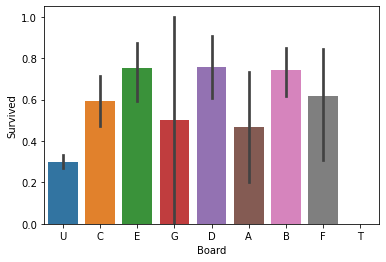

In [14]:
datas['Cabin'] = datas['Cabin'].fillna('U')
datas['Board']=datas['Cabin'].str.get(0)
sns.barplot(x="Board", y="Survived", data=datas)

### 3.2.4 票号的处理

In [15]:
datas['Ticket'].value_counts()

CA. 2343            11
1601                 8
CA 2144              8
3101295              7
347082               7
                    ..
2690                 1
345774               1
363272               1
SOTON/OQ 3101316     1
F.C. 12998           1
Name: Ticket, Length: 929, dtype: int64

**可以看到，票号并不是单独唯一值，而是可以多个乘客同时拥有相同的票号的。**

**那么可以做出一个大胆的假设，这可能与家属数据有关系，同票号的原因可能是因为同一个家庭共用一个票号，放在现实当中就是相当于购买了一张家庭票。**

**这样的话就可以根据某张票同票号的乘客数量来对特征进行分类。**

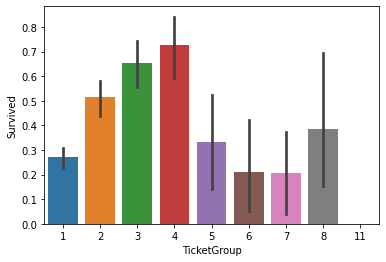

In [16]:
Ticket_Counts = dict(datas['Ticket'].value_counts())
datas['TicketGroup'] = datas['Ticket'].apply(lambda x:Ticket_Counts[x])
sns.barplot(x='TicketGroup', y='Survived', data=datas)

**可以看到，同票号数2~4的’ticket’存活率比其他都高，这与我们的家属数据‘FamilySize’有着相同的规律，所以猜测应该是正确的。**

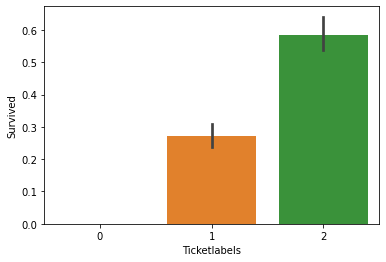

In [17]:
datas.loc[datas['TicketGroup']>8,'Ticketlabels']=0
datas.loc[(datas['TicketGroup']>4)&(datas['TicketGroup']<=8)|(datas['TicketGroup']==1),'Ticketlabels']=1
datas.loc[(datas['TicketGroup']>=2)&(datas['TicketGroup']<=4),'Ticketlabels']=2
datas['Ticketlabels']=datas['Ticketlabels'].astype(np.int32)
sns.barplot(x='Ticketlabels', y='Survived', data=datas)

### 3.2.5 港口号码的处理

In [18]:
datas[datas['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Title,Fam_size,Fam_type,Board,TicketGroup,Ticketlabels
61,62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,1,Miss,1,1,B,2,2
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,1,Mrs,1,1,B,2,2


港口号码的缺失值比较少，只有2个，一般可以直接用众数来进行填补。

**但在泰坦尼克号数据集上，登舱的港口可能与社会等级还有票价挂钩，所以先看一下港口号和社会等级的关联。**

In [19]:
datas.groupby(by=["Pclass","Embarked"]).Fare.median()

Pclass  Embarked
1       C           76.7292
        Q           90.0000
        S           52.0000
2       C           15.3146
        Q           12.3500
        S           15.3750
3       C            7.8958
        Q            7.7500
        S            8.0500
Name: Fare, dtype: float64

In [20]:
datas['Embarked'] = datas['Embarked'].fillna('C')

### 3.2.6 票价的处理（原理与港口号码的处理相同，根据社会等级和票价的关系进行填补）

In [21]:
datas[datas['Fare'].isnull()]
fare=datas[(datas['Embarked'] == "S") & (datas['Pclass'] == 3)].Fare.median()
datas['Fare']=datas['Fare'].fillna(fare)

### 3.2.7 年龄的处理

由于年龄的缺失值非常的多，单独使用众数或者平均数进行填补是不合理的。而且与年龄相关的特征比较多，有社会等级，性别，姓名等等，所以采用另一个填补方法：**随机森林回归树进行填补**

In [22]:
from sklearn.ensemble import RandomForestRegressor
ages = datas[['Age', 'Pclass','Sex','Title']]
ages=pd.get_dummies(ages)
known_ages = ages[ages.Age.notnull()].values
unknown_ages = ages[ages.Age.isnull()].values
y = known_ages[:, 0]
X = known_ages[:, 1:]
rfr = RandomForestRegressor(random_state=60, n_estimators=100, n_jobs=-1)
rfr.fit(X, y)
pre_ages = rfr.predict(unknown_ages[:, 1::])
datas.loc[ (datas.Age.isnull()), 'Age' ] = pre_ages

### 3.2.8 异常值处理
把姓氏相同的乘客划分为同一组，从人数大于一的组中分别提取出每组的妇女儿童和成年男性。

In [23]:
datas['Surname']=datas['Name'].apply(lambda x:x.split(',')[0].strip())
Surname_Count = dict(datas['Surname'].value_counts())
datas['FamilyGroup'] = datas['Surname'].apply(lambda x:Surname_Count[x])
Female_Child_Group=datas.loc[(datas['FamilyGroup']>=2) & ((datas['Age']<=12) | (datas['Sex']=='female'))]
Male_Adult_Group=datas.loc[(datas['FamilyGroup']>=2) & (datas['Age']>12) & (datas['Sex']=='male')]

发现绝大部分女性和儿童组的平均存活率都为1或0，即同组的女性和儿童要么全部幸存，要么全部遇难。

Text(0.5, 0, 'AverageSurvived')

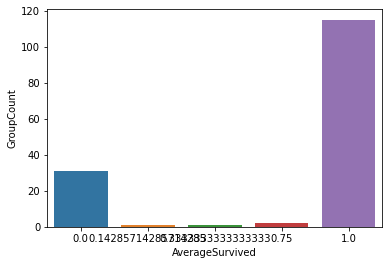

In [24]:
Female_Child=pd.DataFrame(Female_Child_Group.groupby('Surname')['Survived'].mean().value_counts())
Female_Child.columns=['GroupCount']
sns.barplot(x=Female_Child.index, y=Female_Child["GroupCount"]).set_xlabel('AverageSurvived')

绝大部分成年男性组的平均存活率也为1或0。

In [25]:
Male_Adult=pd.DataFrame(Male_Adult_Group.groupby('Surname')['Survived'].mean().value_counts())
Male_Adult.columns=['GroupCount']
Male_Adult

,GroupCount
0.000000,122
1.000000,20
0.500000,6
0.333333,2
0.250000,1


**普遍规律是女性和儿童幸存率高，成年男性幸存较低，所以我们把不符合普遍规律的反常组选出来单独处理。把女性和儿童幸存率为0的组设置为遇难组，把成年男性存活率为1的组设置为幸存组。**

In [26]:
Female_Child_Group=Female_Child_Group.groupby('Surname')['Survived'].mean()
Dead_List=set(Female_Child_Group[Female_Child_Group.apply(lambda x:x==0)].index)
print(Dead_List)
Male_Adult_List=Male_Adult_Group.groupby('Surname')['Survived'].mean()
Survived_List=set(Male_Adult_List[Male_Adult_List.apply(lambda x:x==1)].index)
print(Survived_List)

{'Jussila', 'Rosblom', 'Boulos', 'Rice', 'Lefebre', 'Turpin', 'Skoog', 'Ford', 'Oreskovic', 'Lobb', 'Robins', 'Bourke', 'Attalah', 'Panula', 'Danbom', 'Barbara', 'Palsson', 'Arnold-Franchi', 'Cacic', 'Zabour', 'Vander Planke', 'Caram', 'Canavan', 'Van Impe', 'Ilmakangas', 'Lahtinen', 'Goodwin', 'Sage', 'Olsson', 'Strom', 'Johnston'}
{'Jussila', 'Kimball', 'Goldenberg', 'Bradley', 'Harder', 'Duff Gordon', 'Beane', 'Jonsson', 'Chambers', 'Taylor', 'Frolicher-Stehli', 'McCoy', 'Cardeza', 'Nakid', 'Dick', 'Beckwith', 'Greenfield', 'Daly', 'Frauenthal', 'Bishop'}


为了使处于这两种反常组中的样本能够被正确分类，对测试集中处于反常组中的样本的Age，Title，Sex进行惩罚修改。

In [27]:
train=datas.loc[datas['Survived'].notnull()]
test=datas.loc[datas['Survived'].isnull()]
test.loc[(test['Surname'].apply(lambda x:x in Dead_List)),'Sex'] = 'male'
test.loc[(test['Surname'].apply(lambda x:x in Dead_List)),'Age'] = 60
test.loc[(test['Surname'].apply(lambda x:x in Dead_List)),'Title'] = 'Mr'
test.loc[(test['Surname'].apply(lambda x:x in Survived_List)),'Sex'] = 'female'
test.loc[(test['Surname'].apply(lambda x:x in Survived_List)),'Age'] = 5
test.loc[(test['Surname'].apply(lambda x:x in Survived_List)),'Title'] = 'Miss'

### 3.2.9 重新划分数据，分出训练集和测试集

In [28]:
datas=pd.concat([train, test])
datas=datas[['Survived','Pclass','Sex','Age','Fare','Embarked','Title','Fam_type','Board','Ticketlabels']]
datas=pd.get_dummies(datas)
train=datas[datas['Survived'].notnull()]
test=datas[datas['Survived'].isnull()].drop('Survived',axis=1)
X = train.values[:,1:]
y = train.values[:,0]

# 4 数据建模和调参优化

## 4.1 模型的选择

模型的选择非常关键，kaggle社区中大部分参赛选手使用的是随机森林分类器,这说明决策树在我们泰坦尼克号数据集上有着比较好的效果。而我们小组第一次进行建模的时候使用的是svc，经过svc的kernel参数的调参得出，这是一个线性的数据集，虽然用svc处理能够得到比较好的效果，但处理线性数据我们有更好的选择：逻辑回归

## 4.2 利用逻辑回归建模与调参优化

建立逻辑回归模型并画出第一个重要参数C的学习曲线，找到最佳的C值

0.8047440699126092 1.01


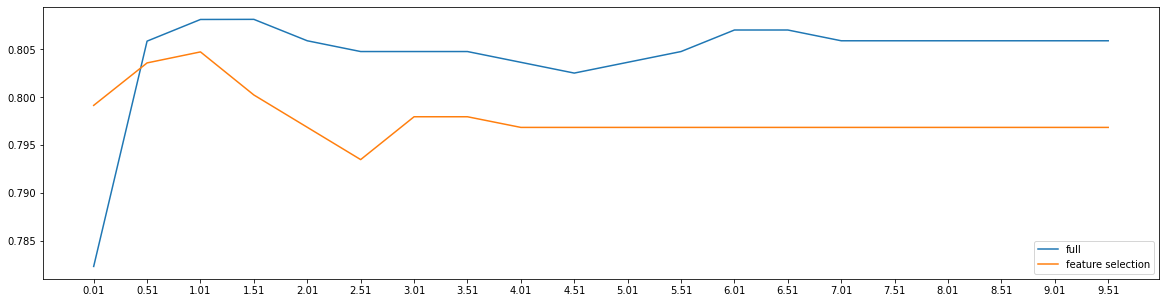

In [29]:
from sklearn.linear_model import LogisticRegression as LR
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

fullx = []
fsx = []

C=np.arange(0.01,10.01,0.5)
for i in C:
    LR_ = LR(solver="liblinear",C=i,random_state=420)
    fullx.append(cross_val_score(LR_,X,y,cv=10).mean())
    X_embedded = SelectFromModel(LR_,norm_order=1).fit_transform(X,y)
    fsx.append(cross_val_score(LR_,X_embedded,y,cv=10).mean())
    
print(max(fsx),C[fsx.index(max(fsx))])
plt.figure(figsize=(20,5))
plt.plot(C,fullx,label="full")
plt.plot(C,fsx,label="feature selection")
plt.xticks(C)
plt.legend()
plt.show()


通过曲线可以找到最佳的C值在1.01附近，我们再一次对C值的范围进行细分，找到最终的C值

0.8058676654182271 0.9850000000000004


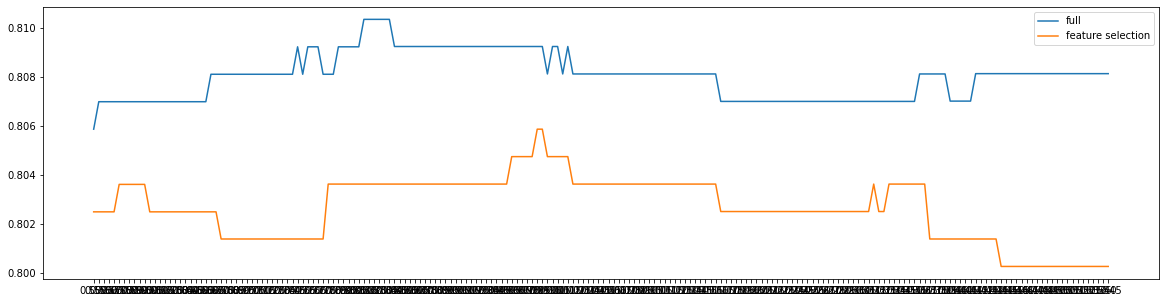

In [30]:
fullx = []
fsx = []
C=np.arange(0.55,1.55,0.005)
for i in C:
    LR_ = LR(solver="liblinear",C=i,random_state=420)
    fullx.append(cross_val_score(LR_,X,y,cv=10).mean())
    X_embedded = SelectFromModel(LR_,norm_order=1).fit_transform(X,y)
    fsx.append(cross_val_score(LR_,X_embedded,y,cv=10).mean())
    
print(max(fsx),C[fsx.index(max(fsx))])
plt.figure(figsize=(20,5))
plt.plot(C,fullx,label="full")
plt.plot(C,fsx,label="feature selection")
plt.xticks(C)
plt.legend()
plt.show()


找到了最佳的C值：0.9850000000000004，将它代到我们的模型中，并开始调整第二个关键参数max_iter，同样的，我们画出max_iter的学习曲线

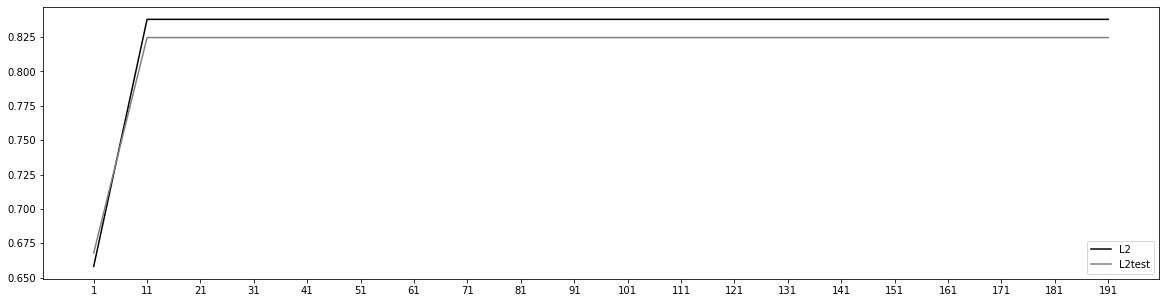

In [31]:
from sklearn.model_selection import train_test_split
l2 = []
l2test = []
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X,y,test_size=0.3,random_state=420)
for i in np.arange(1,201,10):
    lrl2 = LR(penalty="l2",solver="liblinear",C=0.9850000000000004,max_iter=i)
    lrl2 = lrl2.fit(Xtrain,Ytrain)
    l2.append(accuracy_score(lrl2.predict(Xtrain),Ytrain))
    l2test.append(accuracy_score(lrl2.predict(Xtest),Ytest))
    
graph = [l2,l2test]
color = ["black","gray"]
label = ["L2","L2test"]

plt.figure(figsize=(20,5))
for i in range(len(graph)):
    plt.plot(np.arange(1,201,10),graph[i],color[i],label=label[i])
plt.legend(loc=4)
plt.xticks(np.arange(1,201,10))
plt.show()

可以看到max_iter在11之后对模型的作用已经达到了上限，所以可以取一个任意值，我们小组使用的是200。现在用我们得到的最佳参数来进行建模C=0.9850000000000004，max_iter=200

In [32]:
lr = LR(penalty="l2",solver="liblinear",C=0.9850000000000004,max_iter=200).fit(X,y)
cross_val_score(lr,X,y,cv=10).mean()

0.809250936329588

交叉验证的得分还不错，达到了80.9%

In [33]:
predictions = lr.predict(test)
test=pd.read_csv('test.csv')
PassengerId=test['PassengerId']
prdict_test = pd.DataFrame({"PassengerId": PassengerId, "Survived": predictions.astype(np.int32)})
prdict_test.to_csv("prdict_test.csv", index=False)

最后保存并上传到kaggle上，就可以对模型进行评分

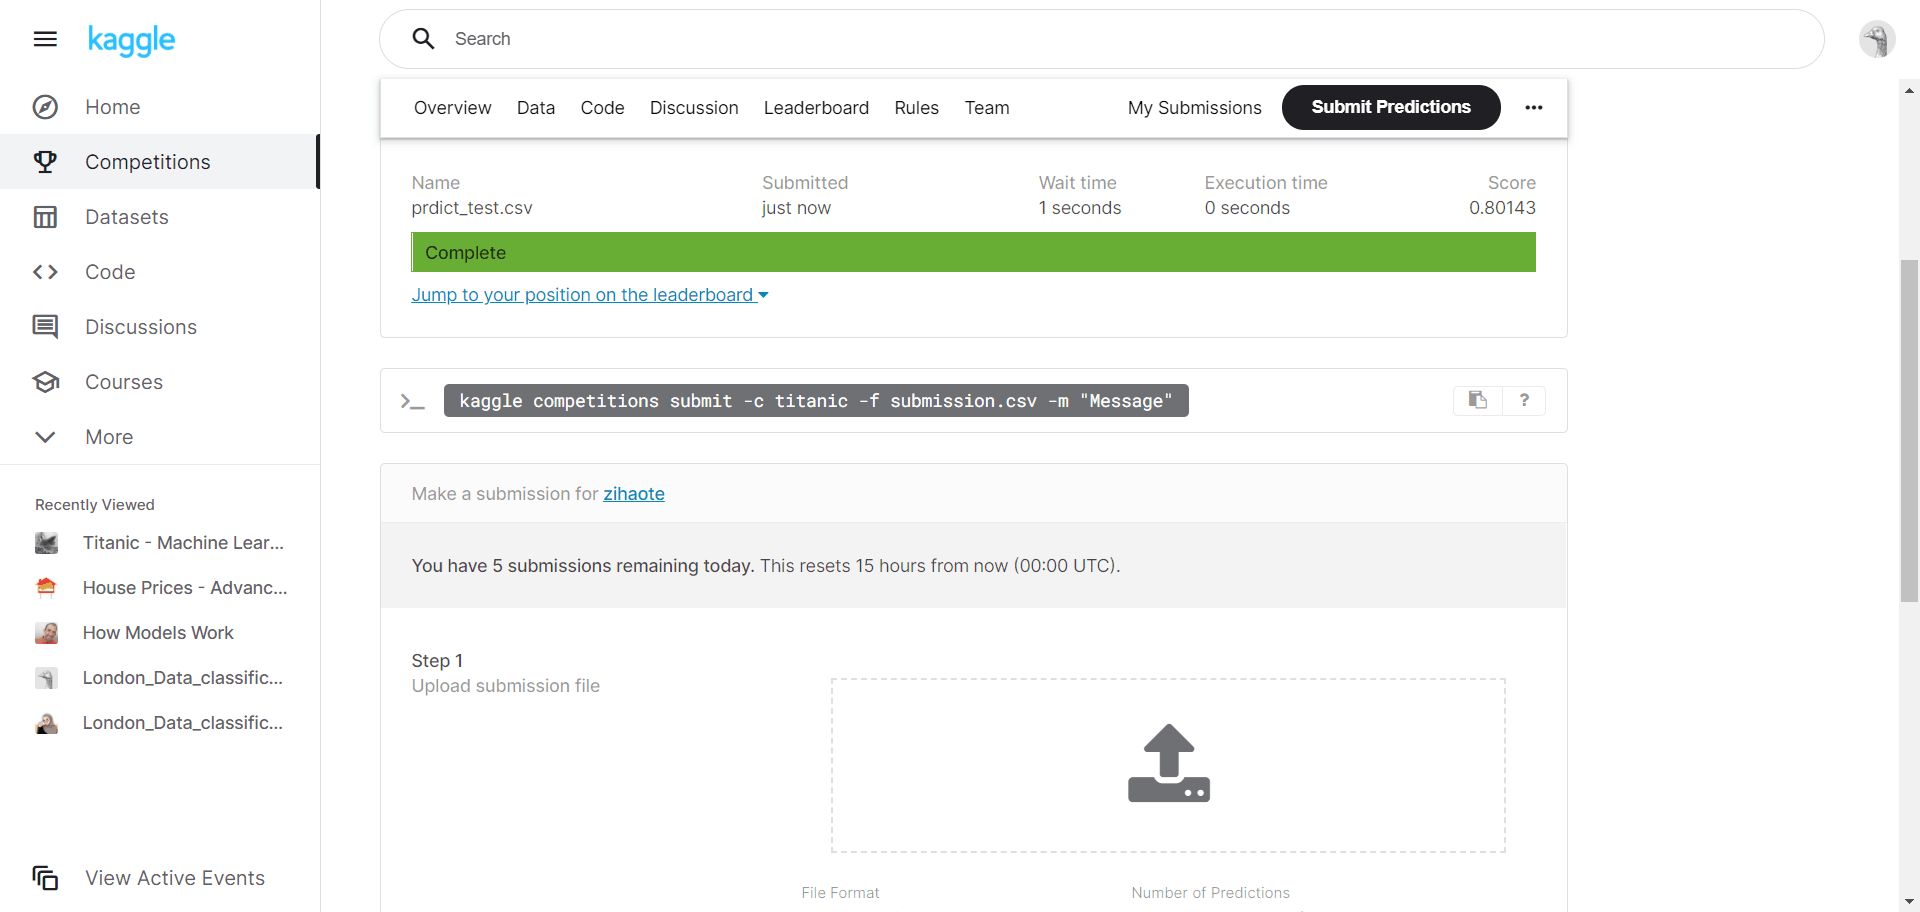

我们的提交结果在kaggle的排名：

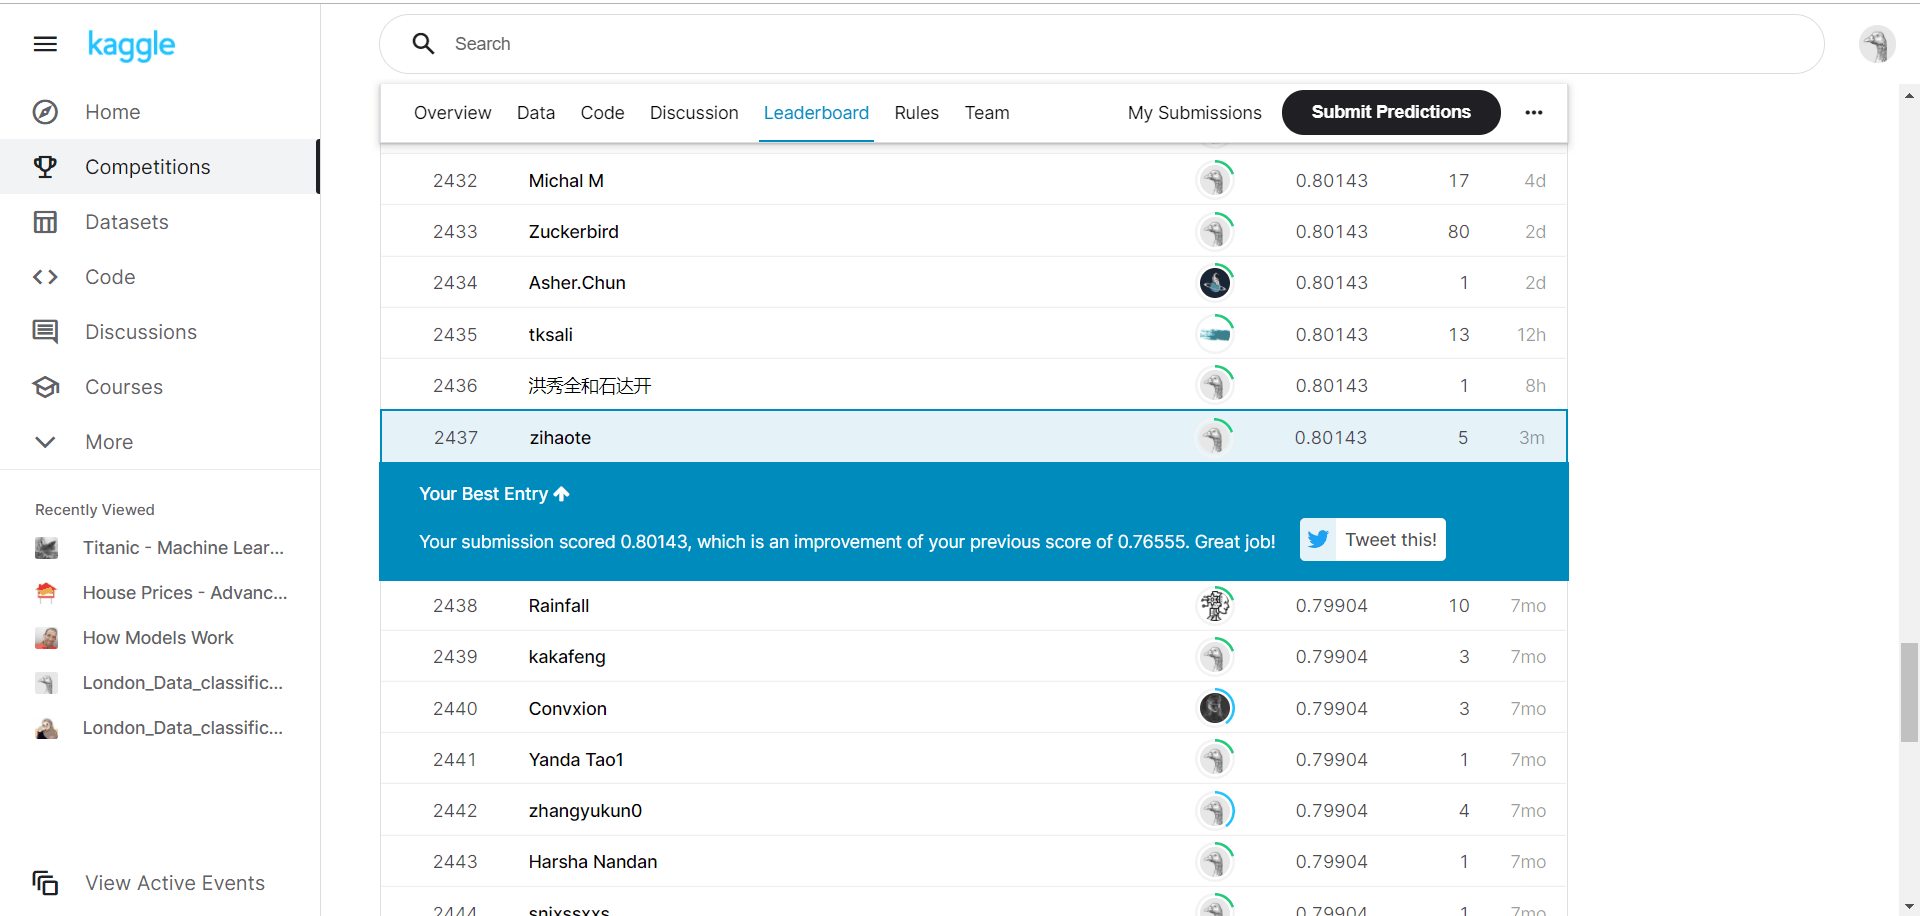